In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Load the dataset
df = pd.read_csv('final_shuffled.csv')

X = df.drop(columns=['subject_id', 'label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data loaded and split.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Data loaded and split.
Training set shape: (320, 19)
Test set shape: (80, 19)


/Users/shubham/Desktop/PROJECTS/HACKWELL_PROJECT/myenv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [21:03:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


AUROC: 0.9974
AUPRC: 0.9960


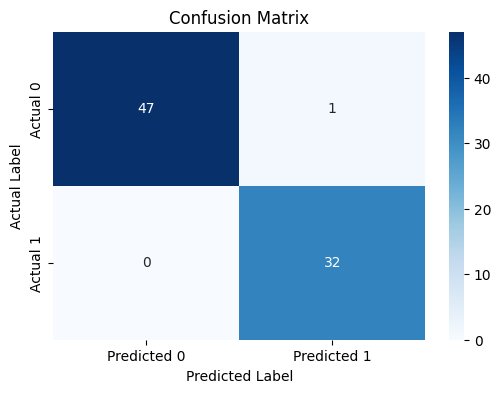

/var/folders/m1/00hnz85n66gbxg871241zmt80000gn/T/ipykernel_8151/2095376320.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration_df = df_test.groupby('y_prob_bin').agg(


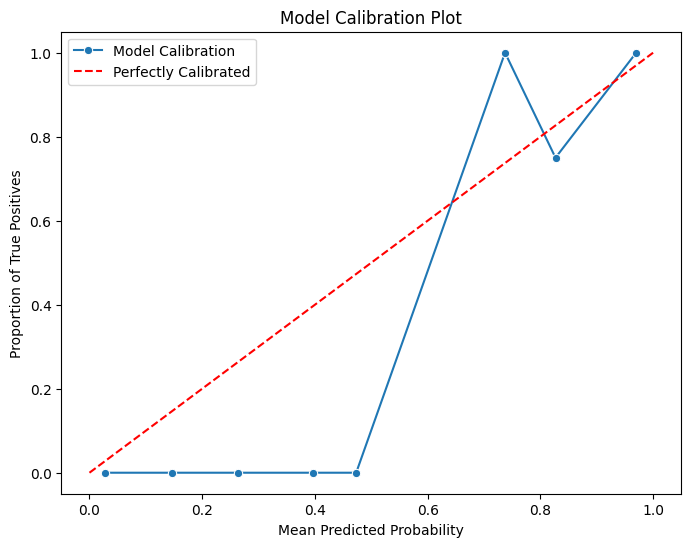

In [8]:

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1,
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

auroc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {auroc:.4f}")


precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auprc = auc(recall, precision)
print(f"AUPRC: {auprc:.4f}")


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show() 



df_test = X_test.copy()
df_test['y_true'] = y_test
df_test['y_prob'] = y_pred_proba
df_test['y_prob_bin'] = pd.cut(df_test['y_prob'], bins=10, labels=np.arange(10))
calibration_df = df_test.groupby('y_prob_bin').agg(
    count=('y_true', 'size'),
    mean_prob=('y_prob', 'mean'),
    mean_true=('y_true', 'mean')
).dropna().reset_index()

plt.figure(figsize=(8, 6))
sns.lineplot(x='mean_prob', y='mean_true', data=calibration_df, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], 'r--', label='Perfectly Calibrated')
plt.title('Model Calibration Plot')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Proportion of True Positives')
plt.legend()
plt.show()

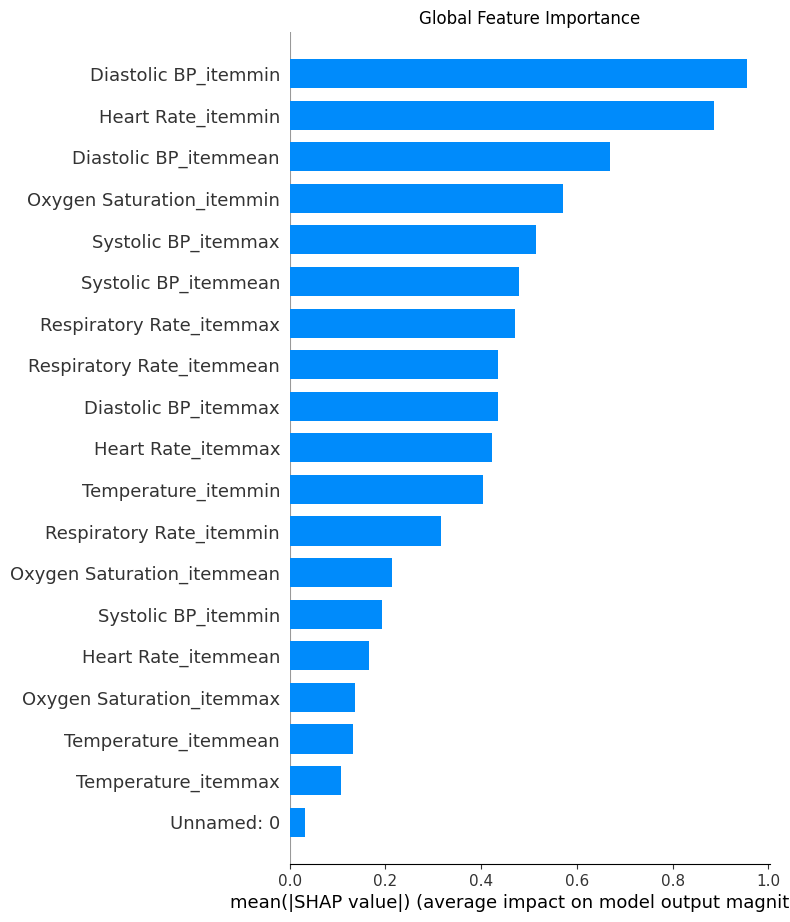


Explaining Prediction for Patient 16:
  Predicted Probability of Deterioration: 0.08%
  Actual Label: 0


Top Risk Drivers 
  • High Temperature (last: 0.9) increased risk by 0.31
  • High Diastolic BP (last: 71.6) increased risk by 0.27
  • High Respiratory Rate (last: 21.2) increased risk by 0.24
Protective Factors
  • Low Systolic BP (last: 121.3) reduced risk by 1.01
  • Low Heart Rate (last: 85.8) reduced risk by 1.10
  • Low Diastolic BP (last: 62.8) reduced risk by 1.59


In [9]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('Global Feature Importance')
plt.show()

patient_index = np.random.randint(0, len(X_test))
patient_data = X_test.iloc[[patient_index]]
patient_true_label = y_test.iloc[patient_index]
patient_prob = model.predict_proba(patient_data)[:, 1][0]

print(f"\nExplaining Prediction for Patient {patient_index}:")
print(f"  Predicted Probability of Deterioration: {patient_prob:.2%}")
print(f"  Actual Label: {patient_true_label}")

shap.initjs()
shap_values_patient = explainer.shap_values(patient_data)
shap.force_plot(explainer.expected_value, shap_values_patient, patient_data, show=False)


def explain_patient(patient_data, shap_values, features_to_show=3):
    feature_contributions = pd.DataFrame({
        'feature': patient_data.columns,
        'value': patient_data.iloc[0].values,
        'contribution': shap_values[0]
    }).sort_values(by='contribution', ascending=False)

    top_drivers = feature_contributions.head(features_to_show)
    bottom_drivers = feature_contributions.tail(features_to_show)
    
    print("Top Risk Drivers ")
    for _, row in top_drivers.iterrows():
        print(f"  • High {row['feature'].split('_')[0]} (last: {row['value']:.1f}) increased risk by {row['contribution']:.2f}")

    print("Protective Factors")
    for _, row in bottom_drivers.iterrows():
        print(f"  • Low {row['feature'].split('_')[0]} (last: {row['value']:.1f}) reduced risk by {-row['contribution']:.2f}")

explain_patient(patient_data, shap_values_patient)

In [10]:

cohort_df = pd.DataFrame({
    'patient_id': X_test.index,
    'predicted_prob': y_pred_proba,
    'risk_band': pd.cut(y_pred_proba, bins=[0, 0.2, 0.5, 1.0], labels=['Low', 'Medium', 'High']),
    'is_deteriorated_actual': y_test.values
})
print("\n--- Cohort View (First 10 Patients) ---")
print(cohort_df.head(10).to_markdown(index=False))

def get_patient_detail_view(patient_id):
    
    patient_df = X_test.loc[[patient_id]]
    patient_prob = cohort_df.loc[cohort_df['patient_id'] == patient_id, 'predicted_prob'].values[0]
    
    print(f"\n--- Patient Detail View for Patient {patient_id} ---")
    print(f"Predicted 90-day Deterioration Risk: {patient_prob:.2%}")
    print(f"Risk Band:{cohort_df.loc[cohort_df['patient_id'] == patient_id, 'risk_band'].values[0]}")
    
   
    shap_values_patient = explainer.shap_values(patient_df)
    explain_patient(patient_df, shap_values_patient)

   
    print("Suggested Next Actions:")
    print("  • Consider medication review for adherence or polypharmacy.")
    print("  • Arrange outpatient follow-up for high-risk labs (e.g., glucose, creatinine).")
    print("  • Schedule a follow-up telehealth visit within 2 weeks to check on vital sign trends.")


get_patient_detail_view(cohort_df['patient_id'].iloc[0])


--- Cohort View (First 10 Patients) ---
|   patient_id |   predicted_prob | risk_band   |   is_deteriorated_actual |
|-------------:|-----------------:|:------------|-------------------------:|
|          365 |       0.953771   | High        |                        1 |
|          397 |       0.144319   | Low         |                        0 |
|          324 |       0.0145337  | Low         |                        0 |
|           73 |       0.0132173  | Low         |                        0 |
|          312 |       0.0183297  | Low         |                        0 |
|          391 |       0.0667095  | Low         |                        0 |
|          355 |       0.989314   | High        |                        1 |
|          119 |       0.012991   | Low         |                        0 |
|          113 |       0.00528193 | Low         |                        0 |
|           89 |       0.0207988  | Low         |                        0 |

--- Patient Detail View for Patien

In [11]:
from sklearn.metrics import classification_report


report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.97      1.00      0.98        32

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

